In [ ]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [27]:
ls data

dataset.zip      tub_4_22-10-25/  tub_6_22-11-01/  tub_8_22-11-03/
tub_3_22-10-25/  tub_5_22-10-27/  tub_7_22-11-01/  zebra_dataset/


In [28]:
images = []
data_folder = "data/zebra_dataset"
for subfolder_name in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, subfolder_name)
    for img in os.listdir(subfolder_path):
        bgr = cv2.imread(os.path.join(subfolder_path, img))
        images.append(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    print(f"{subfolder_name}: {len(os.listdir(subfolder_path))} images")

with_people: 2693 images
without_people: 2647 images


In [29]:
images = np.array(images)
images.shape

(5340, 120, 160, 3)

In [30]:
labels = np.concatenate((np.zeros(2647), np.ones(2693)))
labels = labels.astype(np.uint8)

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

In [32]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [33]:
len(X_train), len(X_test)

(4272, 1068)

In [34]:
mu = np.mean(X_train, axis=(0,1,2)) # finds mean of R, G and B separately
std = np.std(X_train, axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

In [18]:
x = Input(shape=(120, 160, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
p2 = MaxPooling2D(pool_size=2)(a1)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
# Is okay that I used 10 units in the following layer though I have only a binary classification
z = Dense(1)(d3)
p = Activation('sigmoid')(z)

In [19]:
smaller_model = Model(inputs=x, outputs=p)
smaller_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
smaller_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 160, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 120, 160, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 120, 160, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 80, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 153600)            0   

In [20]:
history_smaller = smaller_model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
61/61 [==============================] - 2s 30ms/step - loss: 0.2822 - accuracy: 0.8923 - val_loss: 0.1980 - val_accuracy: 0.9650
Epoch 2/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0874 - accuracy: 0.9854 - val_loss: 0.2103 - val_accuracy: 0.9556
Epoch 3/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0608 - accuracy: 0.9896 - val_loss: 0.3028 - val_accuracy: 0.8505
Epoch 4/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0510 - accuracy: 0.9912 - val_loss: 0.1170 - val_accuracy: 0.9720
Epoch 5/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0410 - accuracy: 0.9919 - val_loss: 0.1376 - val_accuracy: 0.9626
Epoch 6/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0379 - accuracy: 0.9925 - val_loss: 0.0844 - val_accuracy: 0.9813
Epoch 7/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0404 - accuracy: 0.9925 - val_loss: 0.0790 - val_accuracy: 0.9813
Epoch 8/20
61

Text(0.5, 1.0, 'Accuracy')

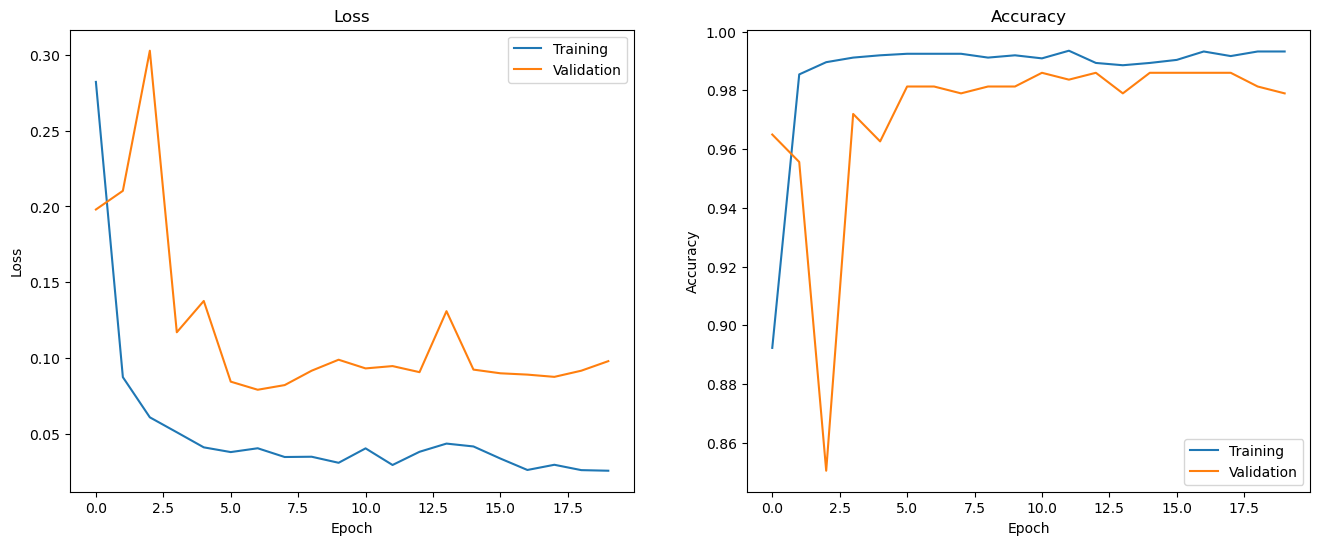

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_smaller.history['loss'])
plt.plot(history_smaller.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_smaller.history['accuracy'])
plt.plot(history_smaller.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [22]:
smaller_model.evaluate(X_test_norm, y_test)

34/34 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.9869


[0.08104550838470459, 0.9868913888931274]

In [23]:
smaller_model.save("models/pedestrian_detector")

2022-11-17 18:02:57.169241: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/pedestrian_detector/assets


In [1]:
from tensorflow.keras.models import load_model
model = load_model("models/pedestrian_detector")

2022-11-22 10:41:42.919734: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/perl-5.34.1-4ryb2w6tlh6ha54x25kkpq7l5zjq56do/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/pcre2-10.36-viek2bpe7b5ktcr3qpyl2qhipy2ybjxs/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/curl-7.83.0-yzcvzf3nqftyqhrki2zketnom3lbg3kf/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/openssl-1.1.1l-er4z7dmuhilyld5dppqjyexmqeh3sgt3/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/zlib-1.2.9-5f6os64uxcqi6maa562tiez2sfoiev6j/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/libidn2-2.3.0-qmmoo5lcgqh4crq2cbbwqe26b6ujugzx/lib:/gpfs/space/so

In [44]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 4ms/step - loss: 669.7554 - accuracy: 0.4963


[669.75537109375, 0.49625468254089355]

In [32]:
np.array((X_test_norm[0],)).shape

(1, 120, 160, 3)

In [25]:
model.predict(np.array([X_test_norm[1005]]))

array([[0.9997203]], dtype=float32)

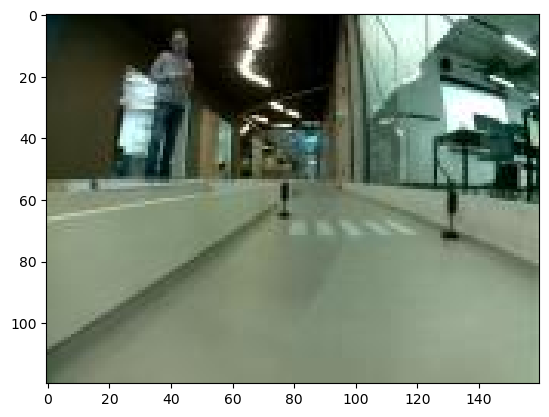

In [26]:
plt.imshow(X_test[1005])